In [1]:
import numpy as np
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
# 平滑化
    
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [3]:
# 前処理

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [4]:
# 8:2にtrain_test_split

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# 【問題1】全結合層のクラス化

# Layer

In [5]:
class FC:
    
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.optimizer = optimizer
        
        # initializer のメソッドを実行し初期値を生成、以後更新
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
       
        self.X = None
        self.dZ = None
        
    
    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        
        # 入力Xをコントラクタに保存、backwardで使う
        self.X = X
        
        # アフィン変換
        A = X.dot(self.W) + self.B

        return A
    
    
    def backward(self, dA):
        
        """
        バックワード
        
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
            
        """
        # 前のノードに流す勾配
        self.dZ = np.dot(dA, self.W.T)
        
        # バイアスに流す勾配
        self.dB = np.sum(dA, axis=0)
        
        # 重み行列に流す勾配
        self.dW = np.dot(self.X.T, dA)
        
        # 更新
        self.optimizer.update(self)
        
        return self.dZ

## 【問題4】活性化関数のクラス化

In [6]:
class Tanh:
         
    def forward(self, A):

        self.Z = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
        return self.Z
    
    
    def backward(self, dZ):
        
        dA = dZ*(1 - self.Z)**2
        return dA

In [7]:
class Softmax:
    
    def forward(self, A):
        
        A = A - np.max(A, axis=1, keepdims=True)
        Z = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
        return Z
        
        
    def backward(self, dZ, Y):
        
        batch_size = dZ.shape[0]
        dA = (dZ - Y) / batch_size
        
        loss = (-1)*np.sum(Y * np.log(dZ + 1e-7))  / batch_size
        
        
        return dA, loss

## 【問題5】ReLUクラスの作成

In [22]:
class ReLU:
    
    
    def __init__(self):
        
        self.mask = None
    
    
    def forward(self, A):

        self.mask = (A <= 0)
        Z = np.maximum(0, A)
        return Z
        
    
    def backward(self, dA):
        
        dA[self.mask] = 0
        return dA

## 【問題2】初期化方法のクラス化

# Initializer

In [9]:
class SimpleInitializer():
    
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    
    def __init__(self, sigma=0.01):
        
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2):
        
        """
        重みの初期化
        
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
          
        Returns
        ----------
        W :float
            重みの初期値
            
        """
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
          
        Returns
        ----------
        B :float
            バイアスの初期値
            
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

## 【問題6】重みの初期値

In [10]:
class XavierInitializer:
    
    """
    Xavierの初期値
      
    """
    
    def __init__(self, sigma):
        
        self.sigma = sigma
        
            
    def W(self, n_nodes1, n_nodes2):
        
        """
        重みの初期化
        
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
          
        Returns
        ----------
        W :float
            重みの初期値
            
        """
        self.n_nodes1 = n_nodes1
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
          
        Returns
        ----------
        B :float
            バイアスの初期値
            
        """
        
        self.sigma = 1 / np.sqrt(self.n_nodes1)
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [11]:
class HeInitializer:
    
    """
    Heの初期値
      
    """
    def __init__(self, sigma):
        
        self.sigma = sigma
        
    
    
    
    def W(self, n_nodes1, n_nodes2):
        
        """
        重みの初期化
        
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
          
        Returns
        ----------
        W :float
            重みの初期値
            
        """
        self.n_nodes1 = n_nodes1
        sigma = np.sqrt(2 / n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
          
        Returns
        ----------
        B :float
            バイアスの初期値
            
        """
        
        sigma = np.sqrt(2 / self.n_nodes1)
        B = sigma * np.random.randn(n_nodes2)
        
        return B

## 【問題8】クラスの完成

# Trainer

In [12]:
class ScratchDeepNeuralNetrowkClassifier():
    
    """
    任意の構成で学習と推定が行えるDNNクラス
    
    """
    
    def __init__(self, initializer, optimizer, activator1, activator2, lr = 0.01,  batch_size = 20, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, sigma=0.01, n_epochs=20, verbose = True):
        
        self.verbose = verbose
        
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        self.FC1 = None
        self.FC2 = None
        self.FC3 = None
        
        self.initializer = initializer
        self.optimizer = optimizer
        self.lr = lr
        
        self.activator1 = activator1
        self.activator2 = activator2   
        
        self.sigma = sigma
        
        self.loss = None
        self.val_loss = None
        
        self.loss_hist = []
        self.val_loss_hist = []
        
        
    # 訓練時に１エポック分の処理を行う関数
    def forward_and_backward(self, X, y):
        
        # one-hot変換
        Y = np.identity(10)[y]
        
        
        # サンプルコード2 : フォワード
        A1 = self.FC1.forward(X)
        #print(A1.shape)
        
        Z1 = self.activation1.forward(A1)
        #print(Z1.shape)
        
        A2 = self.FC2.forward(Z1)
        #print(A2.shape)
        
        Z2 = self.activation2.forward(A2)
        #print("Z2"+str(Z2.shape))
        
        A3 = self.FC3.forward(Z2)
        #print("A3"+str(A3.shape))
        
        Z3 = self.activation3.forward(A3)        
        #print("Z3"+str(Z3.shape))
        
    
        # サンプルコード3 : バックワード
        dA3, self.loss = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
        #print("dA3"+str(dA3.shape))
            
        dZ2 = self.FC3.backward(dA3)
        #print("dZ2"+str(dZ2.shape))
        
        dA2 = self.activation2.backward(dZ2)
        #print("dA2"+str(dA2.shape))
        
        dZ1 = self.FC2.backward(dA2)
        #print("dZ1"+str(dZ1.shape))
        
        dA1 = self.activation1.backward(dZ1)
        #print("dA1"+str(dA1.shape))
        
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
        #print(dZ0.shape)
    
    
    # このエポックで更新した重みを使って検証する関数
    def forward_with_loss(self, X, y):
        
        Y = np.identity(10)[y]
        
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        dA3, self.val_loss = self.activation3.backward(Z3, Y) 
        
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.n_nodes1 : 1層目のノード数
        self.n_nodes2 : 2層目のノード数
        self.n_output : 出力層のノード数
        """
        
        # 最初に全ノードを生成
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation1 = self.activator1
    
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation2 = self.activator2
        
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation3 = Softmax()
        
        # 訓練データのミニバッチを生成
        get_mini_batch_train = GetMiniBatch(X, y, batch_size=self.batch_size)
        
        # 検証データのミニバッチを生成
        get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=self.batch_size)
        
        for epoch in range(self.n_epochs):
            
            for mini_X_train, mini_y_train in get_mini_batch_train:
                
                # 順伝播・クロスエントロピー誤差・逆伝播
                self.forward_and_backward(mini_X_train, mini_y_train)
                
            self.loss_hist.append(self.loss)
            
            # 検証
            mini_X_val, mini_y_val = get_mini_batch_val[0]
            self.forward_with_loss(mini_X_val, mini_y_val)
            self.val_loss_hist.append(self.val_loss)
        
            
            if self.verbose:

                print('#'*25)
                print('### Epoch %i'%(epoch+1))
                print('#'*25)
                
                print("訓練データの損失 : {}".format(self.loss))
                print("検証データの損失 : {}".format(self.val_loss))
                
                print()
                
                
    
    def predict(self, X):
        
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        pred = Z3.argmax(axis=1)
        return pred

## 【問題3】最適化手法のクラス化

# Optimizer

In [13]:
class SGD():
    
    """
    確率的勾配降下法
    
    Parameters
    ----------
    lr : 学習率
    
    """
    
    def __init__(self, lr):
        
        self.lr = lr
        
        
    def update(self, layer):
        
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        """

        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB

## 【問題7】最適化手法

In [14]:
class AdaGrad():
    
    """
    確率的勾配降下法
    
    Parameters
    ----------
    lr : 学習率
    
    """
    
    def __init__(self, lr):
        
        self.lr = lr
        self.hW = 1.
        self.hB = 1.
        
    def update(self, layer):
        
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        """
        
        self.hW += np.mean(layer.dW, axis=0)**2
        self.hB += ((np.mean(layer.dB, axis=0))**2).sum(axis=0)
        
        layer.W -= (self.lr / np.sqrt(self.hW)) * layer.dW
        layer.B -= (self.lr / np.sqrt(self.hB)) * layer.dB

# Utility

In [15]:
class GetMiniBatch:
    
    """
    ミニバッチを取得するイテレータ
    
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
      
    """
    
    def __init__(self, X, y, batch_size = 20, seed=0):
        
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
        
    def __len__(self):
        return self._stop
    
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    
    def __iter__(self):
        self._counter = 0
        return self
    
    
    def __next__(self):
        
        if self._counter >= self._stop:
            raise StopIteration()
            
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題9】学習と推定

* 学習率を固定しての比較

### 9-1. SimpleInitializer, SGD, Tanh

In [26]:
dnn = ScratchDeepNeuralNetrowkClassifier(initializer=SimpleInitializer,
                                                                    optimizer = SGD,
                                                                    lr=0.001, 
                                                                    sigma=0.01, 
                                                                    activator1=Tanh(), 
                                                                    activator2=Tanh(), 
                                                                    n_epochs=20,
                                                                    verbose = True
                                                                    )

In [27]:
dnn.fit(X_train, y_train, X_val, y_val)

#########################
### Epoch 1
#########################
訓練データの損失 : 2.298065265680591
検証データの損失 : 2.296691204426268

#########################
### Epoch 2
#########################
訓練データの損失 : 2.2914757343360774
検証データの損失 : 2.2863892406807027

#########################
### Epoch 3
#########################
訓練データの損失 : 2.2694194049314964
検証データの損失 : 2.2663715891896796

#########################
### Epoch 4
#########################
訓練データの損失 : 2.1674769878292275
検証データの損失 : 2.199790120840123

#########################
### Epoch 5
#########################
訓練データの損失 : 1.921051085571674
検証データの損失 : 1.8203078780245339

#########################
### Epoch 6
#########################
訓練データの損失 : 1.7925766111812016
検証データの損失 : 1.8201216107844247

#########################
### Epoch 7
#########################
訓練データの損失 : 1.5315528822785873
検証データの損失 : 1.4902352439239719

#########################
### Epoch 8
#########################
訓練データの損失 : 1.5437039006965125
検証データの損失 : 1.4005303375296547

####

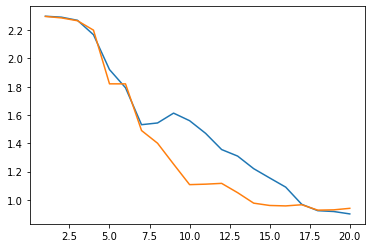

In [28]:
# plot

import matplotlib.pyplot as plt

plt.plot(np.arange(1, dnn.n_epochs+1), dnn.loss_hist)
plt.plot(np.arange(1, dnn.n_epochs+1), dnn.val_loss_hist)

plt.show()

In [29]:
# predict

y_pred = dnn.predict(X_test)
y_pred

array([7, 2, 1, ..., 9, 9, 6])

In [30]:
# Accuracy

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6457

### 9-2. XavierInitializer, SGD, Tanh

In [32]:
dnn2 = ScratchDeepNeuralNetrowkClassifier(initializer=XavierInitializer,
                                                                    optimizer = SGD,
                                                                    lr=0.001, 
                                                                    sigma=0.01, 
                                                                    activator1=Tanh(), 
                                                                    activator2=Tanh(), 
                                                                    n_epochs=20,
                                                                    verbose = True
                                                                    )

In [34]:
dnn2.fit(X_train, y_train, X_val, y_val)

#########################
### Epoch 1
#########################
訓練データの損失 : 2.1172065281882477
検証データの損失 : 1.9459841227905634

#########################
### Epoch 2
#########################
訓練データの損失 : 1.8372932548174625
検証データの損失 : 1.5017392536126772

#########################
### Epoch 3
#########################
訓練データの損失 : 1.6420348191815606
検証データの損失 : 1.2764429472103598

#########################
### Epoch 4
#########################
訓練データの損失 : 1.35621703346212
検証データの損失 : 1.2175922808968846

#########################
### Epoch 5
#########################
訓練データの損失 : 1.2065515804984908
検証データの損失 : 1.207274777097566

#########################
### Epoch 6
#########################
訓練データの損失 : 1.2752287467098367
検証データの損失 : 1.1648702238758846

#########################
### Epoch 7
#########################
訓練データの損失 : 1.2468121225395403
検証データの損失 : 1.1584465316614743

#########################
### Epoch 8
#########################
訓練データの損失 : 1.2386195191243379
検証データの損失 : 1.0528052750891557



<ipython-input-6-2280f3b3b1aa>:5: RuntimeWarning: overflow encountered in exp
  self.Z = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
<ipython-input-6-2280f3b3b1aa>:5: RuntimeWarning: invalid value encountered in true_divide
  self.Z = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))


#########################
### Epoch 9
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 10
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 11
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 12
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 13
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 14
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 15
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 16
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 17
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 18
#########################
訓練データの損失 : nan
検証データの損失 : nan

#########################
### Epoch 19
##

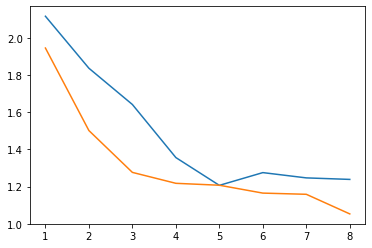

In [35]:
# plot

import matplotlib.pyplot as plt

plt.plot(np.arange(1, dnn2.n_epochs+1), dnn2.loss_hist)
plt.plot(np.arange(1, dnn2.n_epochs+1), dnn2.val_loss_hist)

plt.show()

In [36]:
# predict

y_pred2 = dnn2.predict(X_test)
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
# Accuracy

from sklearn.metrics import accuracy_score

accuracy2 = accuracy_score(y_test, y_pred2)
accuracy2

0.098

### 9-3. XavierInitializer, AdaGrad, Tanh

In [39]:
dnn3 = ScratchDeepNeuralNetrowkClassifier(initializer=XavierInitializer,
                                                                    optimizer = AdaGrad,
                                                                    lr=0.001, 
                                                                    sigma=0.01, 
                                                                    activator1=Tanh(), 
                                                                    activator2=Tanh(), 
                                                                    n_epochs=20,
                                                                    verbose = True
                                                                    )

In [40]:
dnn3.fit(X_train, y_train, X_val, y_val)

#########################
### Epoch 1
#########################
訓練データの損失 : 2.1003482947921066
検証データの損失 : 1.9295988524028036

#########################
### Epoch 2
#########################
訓練データの損失 : 2.0220632657398854
検証データの損失 : 1.8149407326838265

#########################
### Epoch 3
#########################
訓練データの損失 : 1.93305602797238
検証データの損失 : 1.660043235086328

#########################
### Epoch 4
#########################
訓練データの損失 : 1.8900397855404272
検証データの損失 : 1.5395360710747377

#########################
### Epoch 5
#########################
訓練データの損失 : 1.866016451458671
検証データの損失 : 1.4588040738169812

#########################
### Epoch 6
#########################
訓練データの損失 : 1.8445186684809116
検証データの損失 : 1.4183260897604317

#########################
### Epoch 7
#########################
訓練データの損失 : 1.8233766301357597
検証データの損失 : 1.390566717639557

#########################
### Epoch 8
#########################
訓練データの損失 : 1.8013081909631339
検証データの損失 : 1.3657514285372088

#####

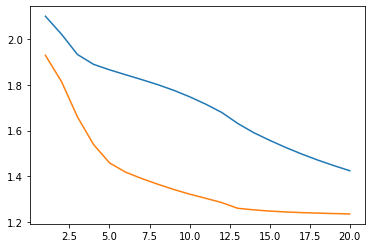

In [41]:
# plot

import matplotlib.pyplot as plt

plt.plot(np.arange(1, dnn3.n_epochs+1), dnn3.loss_hist)
plt.plot(np.arange(1, dnn3.n_epochs+1), dnn3.val_loss_hist)

plt.show()

In [42]:
# predict

y_pred3 = dnn3.predict(X_test)
y_pred3

array([7, 2, 1, ..., 8, 8, 6])

In [43]:
# Accuracy

from sklearn.metrics import accuracy_score

accuracy3 = accuracy_score(y_test, y_pred3)
accuracy3

0.5413

### 9-4. HeInitializer, SGD, ReLU

In [44]:
dnn4 = ScratchDeepNeuralNetrowkClassifier(initializer=HeInitializer,
                                                                    optimizer = SGD,
                                                                    lr=0.001, 
                                                                    sigma=0.01, 
                                                                    activator1=ReLU(), 
                                                                    activator2=ReLU(), 
                                                                    n_epochs=20,
                                                                    verbose = True
                                                                    )

In [45]:
dnn4.fit(X_train, y_train, X_val, y_val)

#########################
### Epoch 1
#########################
訓練データの損失 : 0.7930167396968935
検証データの損失 : 0.9487096179195028

#########################
### Epoch 2
#########################
訓練データの損失 : 0.5126468571817057
検証データの損失 : 0.6082616690020413

#########################
### Epoch 3
#########################
訓練データの損失 : 0.44379824790214323
検証データの損失 : 0.47054744260750925

#########################
### Epoch 4
#########################
訓練データの損失 : 0.4084191865719539
検証データの損失 : 0.3876363821085037

#########################
### Epoch 5
#########################
訓練データの損失 : 0.38492047904571036
検証データの損失 : 0.33158078890131115

#########################
### Epoch 6
#########################
訓練データの損失 : 0.36515624518762085
検証データの損失 : 0.29132796820880924

#########################
### Epoch 7
#########################
訓練データの損失 : 0.34783586454048077
検証データの損失 : 0.26032974039866125

#########################
### Epoch 8
#########################
訓練データの損失 : 0.33234305312369783
検証データの損失 : 0.236168712

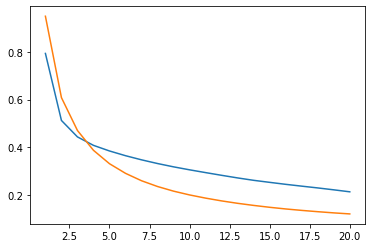

In [46]:
# plot

import matplotlib.pyplot as plt

plt.plot(np.arange(1, dnn4.n_epochs+1), dnn4.loss_hist)
plt.plot(np.arange(1, dnn4.n_epochs+1), dnn4.val_loss_hist)

plt.show()

In [47]:
# predict

y_pred4 = dnn4.predict(X_test)
y_pred4

array([7, 2, 1, ..., 4, 5, 6])

In [48]:
# Accuracy

from sklearn.metrics import accuracy_score

accuracy4 = accuracy_score(y_test, y_pred4)
accuracy4

0.9413

### 9-5. HeInitializer, AdaGrad, ReLU

In [49]:
dnn5 = ScratchDeepNeuralNetrowkClassifier(initializer=HeInitializer,
                                                                    optimizer = AdaGrad,
                                                                    lr=0.001, 
                                                                    sigma=0.01, 
                                                                    activator1=ReLU(), 
                                                                    activator2=ReLU(), 
                                                                    n_epochs=20,
                                                                    verbose = True
                                                                    )

In [50]:
dnn5.fit(X_train, y_train, X_val, y_val)

#########################
### Epoch 1
#########################
訓練データの損失 : 0.8076598877049574
検証データの損失 : 0.9626269890840191

#########################
### Epoch 2
#########################
訓練データの損失 : 0.5243295539007236
検証データの損失 : 0.6255525134576061

#########################
### Epoch 3
#########################
訓練データの損失 : 0.4547959070462671
検証データの損失 : 0.4903074061376736

#########################
### Epoch 4
#########################
訓練データの損失 : 0.4208229230992407
検証データの損失 : 0.40953650003768577

#########################
### Epoch 5
#########################
訓練データの損失 : 0.3990716925026402
検証データの損失 : 0.3548903981613364

#########################
### Epoch 6
#########################
訓練データの損失 : 0.3822143451310139
検証データの損失 : 0.3156328782477468

#########################
### Epoch 7
#########################
訓練データの損失 : 0.36626550993281476
検証データの損失 : 0.2852795719579182

#########################
### Epoch 8
#########################
訓練データの損失 : 0.35178635634275984
検証データの損失 : 0.261001982658054

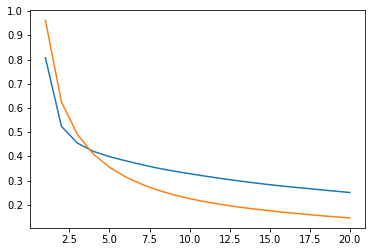

In [51]:
# plot

import matplotlib.pyplot as plt

plt.plot(np.arange(1, dnn5.n_epochs+1), dnn5.loss_hist)
plt.plot(np.arange(1, dnn5.n_epochs+1), dnn5.val_loss_hist)

plt.show()

In [52]:
# predict

y_pred5 = dnn5.predict(X_test)
y_pred5

array([7, 2, 1, ..., 4, 5, 6])

In [53]:
# Accuracy

from sklearn.metrics import accuracy_score

accuracy5 = accuracy_score(y_test, y_pred5)
accuracy5

0.9372